In [51]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [53]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [54]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [55]:
tf.keras.backend.clear_session()

In [56]:
subject = 'Amapá - Consumo de Cimento (t)'
start_index = 0
split_index = 179 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 12

In [57]:
data = pd.read_csv('2003_mo_model_input_AP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Amapá - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,2003-1,0.774101,10518.903600,0.711421,10.392,1.911713,1009.396873,1038.185062,25.663741,22.342619,83.376791,0.991074,2002.738651,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881
1,2003-2,0.774476,10623.124754,0.711553,6.857,1.911107,1009.399285,1039.017226,25.664347,22.345445,83.386754,0.991161,2002.769719,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071
2,2003-3,0.774851,10723.388458,0.711685,7.011,1.910754,1009.400692,1039.502655,25.664701,22.347093,83.392567,0.991211,2002.787842,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261
3,2003-4,0.775226,10817.834529,0.711817,7.122,1.910716,1009.400843,1039.554665,25.664739,22.347270,83.393189,0.991217,2002.789784,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450
4,2003-5,0.775601,10909.780391,0.711949,5.267,1.916050,1009.387499,1037.181846,25.655947,22.352711,83.458581,0.991472,2002.830344,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37300.779456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,37265.020607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,37205.249516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,37124.790031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


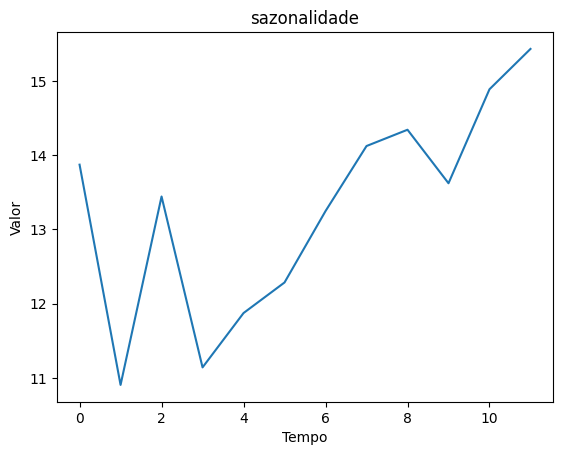

,sazonalidade
sazonalidade,
0,13.872317
1,10.906147
2,13.443547
3,11.142231
4,11.874151
5,12.285879
6,13.247419
7,14.123322
8,14.342659


In [58]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [59]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade,Amapá - Consumo de Cimento (t)
0,2003-1,0.774101,10518.903600,0.711421,1.911713,1009.396873,1038.185062,25.663741,22.342619,83.376791,0.991074,2002.738651,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881,13.872317,10.392
1,2003-2,0.774476,10623.124754,0.711553,1.911107,1009.399285,1039.017226,25.664347,22.345445,83.386754,0.991161,2002.769719,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071,10.906147,6.857
2,2003-3,0.774851,10723.388458,0.711685,1.910754,1009.400692,1039.502655,25.664701,22.347093,83.392567,0.991211,2002.787842,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261,13.443547,7.011
3,2003-4,0.775226,10817.834529,0.711817,1.910716,1009.400843,1039.554665,25.664739,22.347270,83.393189,0.991217,2002.789784,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450,11.142231,7.122
4,2003-5,0.775601,10909.780391,0.711949,1.916050,1009.387499,1037.181846,25.655947,22.352711,83.458581,0.991472,2002.830344,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640,11.874151,5.267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37300.779456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.874151,NaN
245,2023-6,NaN,37265.020607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.285879,NaN
246,2023-7,NaN,37205.249516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.247419,NaN
247,2023-8,NaN,37124.790031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.123322,NaN


In [60]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      9.759
1      4.782
2      7.803
3      4.400
4      4.460
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Amapá - Consumo de Cimento (t), Length: 249, dtype: float64

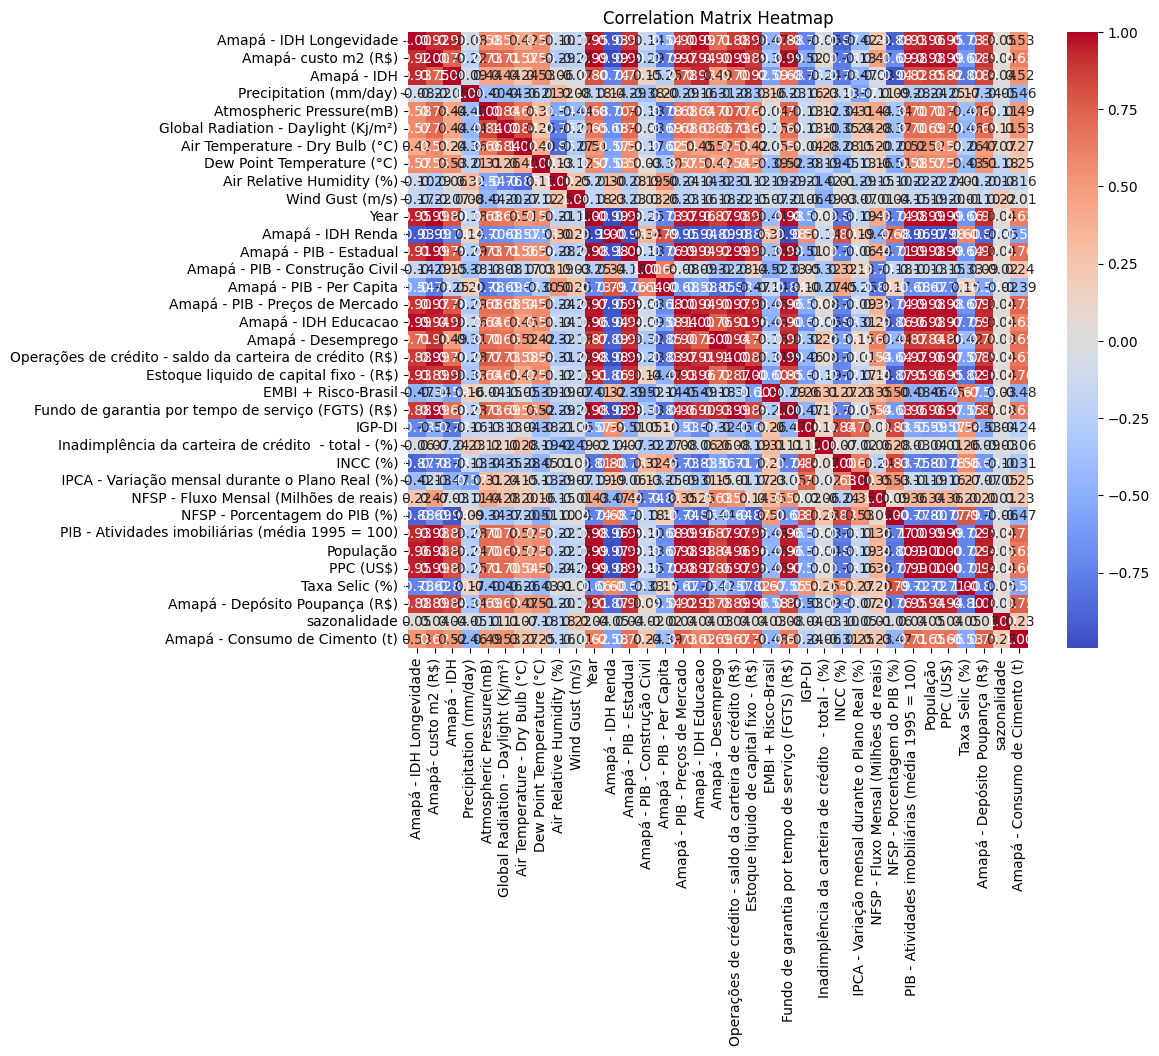

In [61]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [63]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Amapá - IDH Longevidade,5.871086e+08
1,Amapá- custo m2 (R$),1.842746e+05
2,Amapá - IDH,6.777457e+09
3,Precipitation (mm/day),1.117668e+01
4,Atmospheric Pressure(mB),3.398486e+01
5,Global Radiation - Daylight (Kj/m²),3.170932e+01
6,Air Temperature - Dry Bulb (°C),1.782324e+03
7,Dew Point Temperature (°C),4.721945e+02
8,Air Relative Humidity (%),1.353671e+03
9,Wind Gust (m/s),1.878711e+01


In [64]:
data =data.drop(['Wind Gust (m/s)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 11


,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Amapá - PIB - Construção Civil,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade
0,0.774101,10518.903600,1.911713,1038.185062,22.342619,83.376791,0.991074,356591.003430,8.514392,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,205197.602881,13.872317
1,0.774476,10623.124754,1.911107,1039.017226,22.345445,83.386754,0.991161,356647.711004,8.508753,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,205498.444071,10.906147
2,0.774851,10723.388458,1.910754,1039.502655,22.347093,83.392567,0.991211,356704.418579,8.503114,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,205799.285261,13.443547
3,0.775226,10817.834529,1.910716,1039.554665,22.347270,83.393189,0.991217,356761.126153,8.497475,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,206100.126450,11.142231
4,0.775601,10909.780391,1.916050,1037.181846,22.352711,83.458581,0.991472,356817.833728,8.491835,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,206400.967640,11.874151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.801540,25240.735962,2.240843,1394.983662,23.438266,79.181690,1.013795,348111.345937,15.928514,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,498644.254810,14.123322
176,0.801407,25325.896511,2.022909,1547.332746,23.164020,75.319629,1.199209,348171.145980,15.905384,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,500893.355114,14.342659
177,0.801275,25413.808629,2.081550,1551.897379,23.075052,77.694577,1.193376,348230.946024,15.882255,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,503142.455418,13.621906
178,0.801142,25504.242224,2.190737,1573.743992,23.094888,79.520941,1.183044,348290.746067,15.859126,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,505391.555722,14.887834


In [65]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amapá- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Amapá - PIB - Construção Civil,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,-1.608720,-0.114839,-0.197261,-1.390109,-1.099409,-0.515351,-0.636063,-0.825079,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-1.639797
1,-1.585546,-0.115790,-0.194126,-1.384141,-1.096497,-0.514363,-0.627297,-0.826659,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.637262
2,-1.563252,-0.116345,-0.192297,-1.380659,-1.094798,-0.513786,-0.618531,-0.828238,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-1.634726
3,-1.542252,-0.116405,-0.192101,-1.380286,-1.094616,-0.513724,-0.609765,-0.829818,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-1.632190
4,-1.521807,-0.108026,-0.201040,-1.368791,-1.075504,-0.510813,-0.600999,-0.831398,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-1.629655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.664720,0.402083,1.146882,0.924362,-2.325565,-0.256364,-1.946873,1.251965,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938,0.833556
176,1.683655,0.059802,1.720816,0.345037,-3.454379,1.857061,-1.937629,1.245485,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688,0.852513
177,1.703203,0.151903,1.738012,0.157100,-2.760222,1.790576,-1.928385,1.239005,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616,0.871470
178,1.723311,0.323389,1.820313,0.199000,-2.226408,1.672810,-1.919141,1.232526,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772,0.890427


In [66]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amapá- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Amapá - PIB - Construção Civil,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,-1.608720,-0.114839,-0.197261,-1.390109,-1.099409,-0.515351,-0.636063,-0.825079,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-1.639797
1,-1.585546,-0.115790,-0.194126,-1.384141,-1.096497,-0.514363,-0.627297,-0.826659,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.637262
2,-1.563252,-0.116345,-0.192297,-1.380659,-1.094798,-0.513786,-0.618531,-0.828238,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-1.634726
3,-1.542252,-0.116405,-0.192101,-1.380286,-1.094616,-0.513724,-0.609765,-0.829818,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-1.632190
4,-1.521807,-0.108026,-0.201040,-1.368791,-1.075504,-0.510813,-0.600999,-0.831398,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-1.629655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.443397,0.011124,1.339490,-0.256268,-1.375152,-0.774784,-1.856442,1.338092,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090,0.712399
164,1.459776,0.005612,1.184589,-0.453032,-1.384741,-0.593287,-1.887469,1.329938,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875,0.710091
165,1.477126,0.196062,0.852030,-0.526094,-1.053500,-0.673953,-1.918497,1.321784,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030,0.707783
166,1.497134,0.682597,0.512445,-0.397771,-0.502064,-0.781126,-1.949525,1.313630,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803,0.705475


In [67]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       9.759
1       4.782
2       7.803
3       4.400
4       4.460
        ...  
163     9.724
164    10.069
165    13.930
166    11.918
167    11.757
Name: Amapá - Consumo de Cimento (t), Length: 168, dtype: float64

In [68]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [69]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 21)

In [70]:
# input para treinamento
test_input = input_data.iloc[train_split-window_size:split_index + 1]
test_input

,Amapá- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Amapá - PIB - Construção Civil,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
132,0.837085,-1.271428,0.323016,0.921110,0.461638,1.115925,0.622503,1.153708,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376,0.879638
133,0.859675,-1.453027,0.112464,0.888116,0.636302,0.860013,0.545479,1.169540,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859,0.884405
134,0.882395,-1.505903,0.160516,0.938503,0.693930,0.450012,0.468455,1.185371,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952,0.889172
135,0.902877,-1.643096,0.232638,0.942560,0.677425,-0.156355,0.391431,1.201202,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200,0.893938
136,0.924167,-1.784847,0.443483,0.750053,0.516151,-0.612440,0.314407,1.217033,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944,0.898705
137,0.944509,-1.924257,0.865526,0.326595,0.004816,-0.685447,0.237383,1.232864,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692,0.903472
138,0.964695,-2.054428,1.196902,-0.169215,-0.564151,-0.533494,0.160359,1.248696,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126,0.908239
139,0.985190,-2.168462,1.340158,-0.389570,-0.862033,-0.403752,0.083335,1.264527,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065,0.913006
140,1.005600,-2.277486,1.287743,-0.460989,-0.956606,-0.269104,0.006312,1.280358,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206,0.917773
141,1.026304,-2.255276,0.995571,-0.276686,-0.606994,-0.167830,-0.070712,1.296189,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794,0.922539


In [71]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 21)

In [72]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [73]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [74]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [75]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2829336180, 1084249716, 1656329787, 2846285657, 2884086915, 4265139124, 2988038691, 1608866543, 2561716243, 2420791857]


Step: 0 ___________________________________________
val_loss: 2.20577335357666
winner_seed: 2829336180


Step: 1 ___________________________________________
val_loss: 1.8887834548950195
winner_seed: 1084249716


Step: 2 ___________________________________________
val_loss: 2.130582332611084


Step: 3 ___________________________________________
val_loss: 1.7910444736480713
winner_seed: 2846285657


Step: 4 ___________________________________________
val_loss: 1.8167831897735596


Step: 5 ___________________________________________
val_loss: 1.960590124130249


Step: 6 ___________________________________________
val_loss: 2.0101590156555176


Step: 7 ___________________________________________
val_loss: 4.036564350128174


Step: 8 ___________________________________________
val_loss: 1.833387017250061


Step: 9 ___________________________________________
val_loss: 1.

In [76]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2420791857

Epoch 1/10000
4/4 [==============================] - 2s 141ms/step - loss: 218.8643 - val_loss: 24.0205
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 52.3063 - val_loss: 19.2586
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.9217 - val_loss: 11.3382
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.6934 - val_loss: 23.5615
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.3476 - val_loss: 19.6775
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.7871 - val_loss: 7.7181
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.0800 - val_loss: 6.9076
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.5621 - val_loss: 8.2186
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2234 - val_loss: 5.9654
Epoch 10/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.5231 -

Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.7356 - val_loss: 6.4417
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0077 - val_loss: 8.3951
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2050 - val_loss: 5.6262
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9741 - val_loss: 7.8636
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9793 - val_loss: 6.2461
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7781 - val_loss: 5.8240
Epoch 88/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0451 - val_loss: 9.8684
Epoch 89/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.5655 - val_loss: 7.5612
Epoch 90/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5690 - val_loss: 7.4411
Epoch 91/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8685 - val_loss

4/4 [==============================] - 0s 11ms/step - loss: 5.2537 - val_loss: 3.0309
Epoch 243/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8525 - val_loss: 2.7193
Epoch 244/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8839 - val_loss: 3.0636
Epoch 245/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.6141 - val_loss: 2.9697
Epoch 246/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9592 - val_loss: 2.8354
Epoch 247/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7450 - val_loss: 3.0138
Epoch 248/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2848 - val_loss: 3.1043
Epoch 249/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4272 - val_loss: 3.2158
Epoch 250/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.7726 - val_loss: 3.1499
Epoch 251/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.4346 - val_loss: 2.863

4/4 [==============================] - 0s 10ms/step - loss: 4.6750 - val_loss: 3.2567
Epoch 403/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.0010 - val_loss: 3.1537
Epoch 404/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5975 - val_loss: 3.5774
Epoch 405/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9118 - val_loss: 3.3207
Epoch 406/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7400 - val_loss: 3.3769
Epoch 407/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8262 - val_loss: 3.2529
Epoch 408/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4121 - val_loss: 3.4583
Epoch 409/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5982 - val_loss: 3.4371
Epoch 410/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3934 - val_loss: 3.4195
Epoch 411/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.5274 - val_loss: 3.59

4/4 [==============================] - 0s 10ms/step - loss: 4.0538 - val_loss: 4.1150
Epoch 563/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6653 - val_loss: 3.9570
Epoch 564/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8385 - val_loss: 3.9607
Epoch 565/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7261 - val_loss: 3.9096
Epoch 566/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8607 - val_loss: 4.0040
Epoch 567/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1233 - val_loss: 4.0415
Epoch 568/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8586 - val_loss: 4.2029
Epoch 569/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0750 - val_loss: 4.5824
Epoch 570/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7516 - val_loss: 4.5589
Epoch 571/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6992 - val_loss: 4.57

4/4 [==============================] - 0s 11ms/step - loss: 3.2192 - val_loss: 3.9350
Epoch 723/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6249 - val_loss: 3.6116
Epoch 724/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8678 - val_loss: 4.0119
Epoch 725/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6161 - val_loss: 4.4498
Epoch 726/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4421 - val_loss: 3.9873
Epoch 727/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1711 - val_loss: 3.9159
Epoch 728/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1427 - val_loss: 4.0535
Epoch 729/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2862 - val_loss: 3.5192
Epoch 730/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3954 - val_loss: 3.9924
Epoch 731/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.3649 - val_loss: 4.52

4/4 [==============================] - 0s 11ms/step - loss: 3.3263 - val_loss: 4.5976
Epoch 883/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.4197 - val_loss: 4.4745
Epoch 884/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1520 - val_loss: 4.0555
Epoch 885/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9852 - val_loss: 3.9432
Epoch 886/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0365 - val_loss: 4.2219
Epoch 887/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4893 - val_loss: 4.8656
Epoch 888/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0134 - val_loss: 4.2019
Epoch 889/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1612 - val_loss: 3.8742
Epoch 890/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1805 - val_loss: 3.6958
Epoch 891/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0057 - val_loss: 3.8

4/4 [==============================] - 0s 10ms/step - loss: 3.2315 - val_loss: 3.5507
Epoch 1043/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1654 - val_loss: 3.1067
Epoch 1044/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9767 - val_loss: 3.4736
Epoch 1045/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4845 - val_loss: 3.6104
Epoch 1046/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9261 - val_loss: 3.5764
Epoch 1047/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.8849 - val_loss: 3.6398
Epoch 1048/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9581 - val_loss: 3.6322
Epoch 1049/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4501 - val_loss: 3.3186
Epoch 1050/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1806 - val_loss: 3.6082
Epoch 1051/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.8327 - val_lo

4/4 [==============================] - 0s 11ms/step - loss: 2.6272 - val_loss: 2.8429
Epoch 1201/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7333 - val_loss: 2.9758
Epoch 1202/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9920 - val_loss: 3.0668
Epoch 1203/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6876 - val_loss: 2.9067
Epoch 1204/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6971 - val_loss: 2.8456
Epoch 1205/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7297 - val_loss: 3.1482
Epoch 1206/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.5970 - val_loss: 3.0235
Epoch 1207/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.7689 - val_loss: 3.0957
Epoch 1208/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6834 - val_loss: 2.7520
Epoch 1209/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5761 - val_l

Epoch 1280/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5156 - val_loss: 2.9997
Epoch 1281/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.7655 - val_loss: 2.7446
Epoch 1282/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.6058 - val_loss: 2.7766
Epoch 1283/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.4553 - val_loss: 2.6996
Epoch 1284/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6011 - val_loss: 2.9173
Epoch 1285/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.8284 - val_loss: 2.7668
Epoch 1286/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7789 - val_loss: 3.0233
Epoch 1287/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3897 - val_loss: 2.6465
Epoch 1288/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.6542 - val_loss: 2.8447
Epoch 1289/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 2.2888 - val_loss: 2.7422
Epoch 1439/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2689 - val_loss: 2.6126
Epoch 1440/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.6941 - val_loss: 2.4718
Epoch 1441/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2578 - val_loss: 2.9578
Epoch 1442/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3943 - val_loss: 2.6398
Epoch 1443/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3944 - val_loss: 2.6765
Epoch 1444/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3146 - val_loss: 2.6365
Epoch 1445/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3881 - val_loss: 2.8175
Epoch 1446/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3050 - val_loss: 2.3279
Epoch 1447/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.2720 - val_

4/4 [==============================] - 0s 10ms/step - loss: 2.3014 - val_loss: 2.6508
Epoch 1597/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1923 - val_loss: 2.4192
Epoch 1598/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0105 - val_loss: 2.4938
Epoch 1599/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.2365 - val_loss: 2.5930
Epoch 1600/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.3787 - val_loss: 2.5869
Epoch 1601/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0609 - val_loss: 2.6386
Epoch 1602/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2001 - val_loss: 2.5266
Epoch 1603/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9968 - val_loss: 2.6487
Epoch 1604/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.0754 - val_loss: 2.6762
Epoch 1605/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2308 - val_l

4/4 [==============================] - 0s 11ms/step - loss: 1.9484 - val_loss: 2.3157
Epoch 1755/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.9577 - val_loss: 2.3116
Epoch 1756/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0796 - val_loss: 2.3325
Epoch 1757/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8879 - val_loss: 2.4205
Epoch 1758/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0303 - val_loss: 2.2831
Epoch 1759/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9494 - val_loss: 2.1345
Epoch 1760/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9444 - val_loss: 2.2120
Epoch 1761/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.1422 - val_loss: 2.2720
Epoch 1762/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2978 - val_loss: 2.4595
Epoch 1763/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.0283 - val_

4/4 [==============================] - 0s 10ms/step - loss: 1.8650 - val_loss: 2.2093
Epoch 1913/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1398 - val_loss: 2.2569
Epoch 1914/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6717 - val_loss: 2.3129
Epoch 1915/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7386 - val_loss: 2.1754
Epoch 1916/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7897 - val_loss: 2.5621
Epoch 1917/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7674 - val_loss: 2.3246
Epoch 1918/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8220 - val_loss: 2.3693
Epoch 1919/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8627 - val_loss: 2.4718
Epoch 1920/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7221 - val_loss: 2.6544
Epoch 1921/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6862 - val_l

4/4 [==============================] - 0s 11ms/step - loss: 1.4730 - val_loss: 2.1615
Epoch 2071/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8672 - val_loss: 1.8479
Epoch 2072/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.5953 - val_loss: 1.8850
Epoch 2073/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.8234 - val_loss: 1.9184
Epoch 2074/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6678 - val_loss: 1.9178
Epoch 2075/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6311 - val_loss: 1.8532
Epoch 2076/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6280 - val_loss: 1.8546
Epoch 2077/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6170 - val_loss: 2.0410
Epoch 2078/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5663 - val_loss: 2.1871
Epoch 2079/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8270 - val_

4/4 [==============================] - 0s 10ms/step - loss: 1.5024 - val_loss: 2.0656
Epoch 2229/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6929 - val_loss: 2.3097
Epoch 2230/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5041 - val_loss: 2.0474
Epoch 2231/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7211 - val_loss: 1.7499
Epoch 2232/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5311 - val_loss: 2.3260
Epoch 2233/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3809 - val_loss: 1.9187
Epoch 2234/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3944 - val_loss: 1.9954
Epoch 2235/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4512 - val_loss: 1.9610
Epoch 2236/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3791 - val_loss: 2.0851
Epoch 2237/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6191 - val_

Epoch 2308/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4308 - val_loss: 2.2484
Epoch 2309/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4748 - val_loss: 1.8740
Epoch 2310/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3614 - val_loss: 2.0782
Epoch 2311/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3117 - val_loss: 1.8409
Epoch 2312/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4139 - val_loss: 1.8314
Epoch 2313/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5518 - val_loss: 1.9290
Epoch 2314/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5814 - val_loss: 1.8344
Epoch 2315/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4690 - val_loss: 2.0014
Epoch 2316/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5012 - val_loss: 1.9611
Epoch 2317/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 1.3125 - val_loss: 2.2326
Epoch 2467/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5027 - val_loss: 2.0146
Epoch 2468/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2866 - val_loss: 2.2198
Epoch 2469/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4182 - val_loss: 2.4217
Epoch 2470/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.3147 - val_loss: 2.3103
Epoch 2471/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.2718 - val_loss: 1.9786
Epoch 2472/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8550 - val_loss: 2.1531
Epoch 2473/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7256 - val_loss: 2.4177
Epoch 2474/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3679 - val_loss: 2.3869
Epoch 2475/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.3655 - val_

4/4 [==============================] - 0s 10ms/step - loss: 1.1786 - val_loss: 3.4385
Epoch 2625/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1191 - val_loss: 3.7419
Epoch 2626/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1204 - val_loss: 3.7870
Epoch 2627/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1113 - val_loss: 3.4044
Epoch 2628/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2320 - val_loss: 3.1513
Epoch 2629/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1353 - val_loss: 3.8220
Epoch 2630/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1532 - val_loss: 3.5379
Epoch 2631/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1749 - val_loss: 3.8088
Epoch 2632/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2699 - val_loss: 3.7019
Epoch 2633/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4587 - val_

Epoch 2704/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3442 - val_loss: 5.1991
Epoch 2705/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1370 - val_loss: 5.2749
Epoch 2706/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1196 - val_loss: 5.6823
Epoch 2707/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2065 - val_loss: 5.1724
Epoch 2708/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1280 - val_loss: 4.7525
Epoch 2709/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1356 - val_loss: 5.4500
Epoch 2710/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0281 - val_loss: 5.7333
Epoch 2711/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0555 - val_loss: 4.6412
Epoch 2712/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0724 - val_loss: 5.3159
Epoch 2713/10000
4/4 [==============================] - 0s 9ms/step - loss: 1

Epoch 2784/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9104 - val_loss: 4.8089
Epoch 2785/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.3969 - val_loss: 4.6006
Epoch 2786/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2030 - val_loss: 4.7825
Epoch 2787/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.3727 - val_loss: 4.5670
Epoch 2788/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0757 - val_loss: 5.0054
Epoch 2789/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1309 - val_loss: 4.8459
Epoch 2790/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0518 - val_loss: 4.7035
Epoch 2791/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1055 - val_loss: 4.4768
Epoch 2792/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1589 - val_loss: 5.4675
Epoch 2793/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.3

4/4 [==============================] - 0s 8ms/step - loss: 1.0651 - val_loss: 5.7696
Epoch 2865/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0056 - val_loss: 6.0605
Epoch 2866/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9914 - val_loss: 5.7030
Epoch 2867/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0863 - val_loss: 5.6615
Epoch 2868/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0295 - val_loss: 5.6282
Epoch 2869/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9986 - val_loss: 5.4758
Epoch 2870/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9758 - val_loss: 5.4338
Epoch 2871/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9834 - val_loss: 5.4735
Epoch 2872/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0076 - val_loss: 5.4149
Epoch 2873/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1747 - val_loss: 5.18

In [77]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [78]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,9.501208,8.632245,7.668808,7.218593,8.082638,11.798945,12.630874,12.714647,12.7555,12.859158,12.721001,11.775168
Target,9.691,7.378,6.97,7.612,8.442,8.835,11.251,11.342,13.11,13.195,10.053,12.274
Error,0.189792,1.254245,0.698808,0.393407,0.359363,2.963945,1.379873,1.372647,0.3545,0.335842,2.668,0.498832


In [79]:
display(mae)
display(mape)

1.0391046

0.11014714

In [80]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [81]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[128.35878]] - Target[120.15299999999999]| =  Error: [[8.20578]]; MAPE:[[0.06829443]]


[array([[8.20578]], dtype=float32)]

8.20578

0.06829443